In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utilities import train_test_val_split, rmse, load_matlab_data
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
matlab_data = loadmat("data/hwk8data.mat")
print(matlab_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'data', 'test1', 'test2'])


In [4]:
data = matlab_data['data']
test1 = matlab_data['test1']
test2 = matlab_data['test2']

In [5]:
print(data.shape)

(450, 21)


Briefly describe PCA and how it is used for anomaly detection. Describe the use of Q- and T2-statistics for detecting anomalies. Give the equations for calculating the Q- and T2-statistics.

In [6]:
def t2(data, pca):
    """Calculate the T^2 score for a data sample
    """
    l = np.diag(pca.explained_variance_)
    t = pca.transform(data)
    return np.array([tt @ l @ tt.T for tt in t])

In [7]:
def q(data, pca):
    """Calculate Q-score for a data sample
    """
    # Get dimensionality of the data
    i = data.shape[1]
    
    pp = pca.components_.T @ pca.components_
    
    return np.array([x @ (np.eye(i) - pp) @ x.T for x in data])

Develop a PCA model of the normal operating data contained in data.

In [8]:
scale = StandardScaler().fit(data)

In [9]:
data_s = scale.transform(data)

In [10]:
pca = PCA().fit(data_s)

In [11]:
test1_s = scale.transform(test1)
test2_s = scale.transform(test2)

Determine on your own how many PCs should be included in the model.

In [15]:
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)

(array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),)

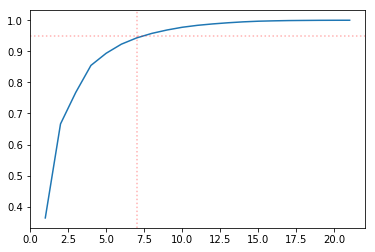

In [17]:
plt.plot(range(1, pca.explained_variance_.shape[0]+1), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=7, color='r', linestyle=':', alpha=0.3)

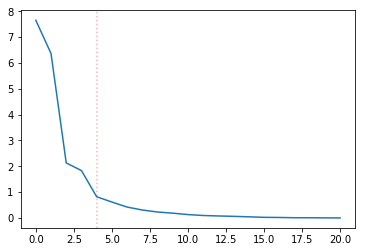

In [20]:
plt.plot(pca.explained_variance_)
plt.axvline(x=4, color='r', linestyle=':', alpha=0.3)

In [22]:
np.sum(pca.explained_variance_ratio_[:5])

0.893705287056583

In [25]:
e = []
for i in range(1, data.shape[1]):
    pc = PCA(n_components=i).fit(data_s)
    p = pc.inverse_transform(pc.transform(data_s))
    res = la.norm(data_s - p) / la.norm(data_s)
    e.append(np.mean(res))

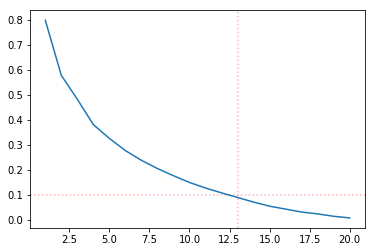

In [28]:
plt.plot(range(1, data.shape[1]), e)
plt.axhline(y=0.1, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=13, color='r', linestyle=':', alpha=0.3)